<a href="https://colab.research.google.com/github/seiching/aischool/blob/master/FaceNet_organize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 參考資料:
1. https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

## 連結google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 解壓縮資料tar(如果資料損毀)

In [0]:
!ls
%cd '/content/drive/My Drive/FaceNet_Colab'
!ls
#!tar -xvf aia-tpe4-who-is-she.tar 
print('\nunzip over')


drive  sample_data
/content/drive/My Drive/FaceNet_Colab
aia-tpe4-who-is-she	 FaceNet_organize.ipynb  result.csv
aia-tpe4-who-is-she.tar  girls_dataset30.npz
facenet_keras.h5	 girls_embeddings30.npz

unzip over


### 1.開始計時

In [0]:
import time
start = time.time()
print("hello...%d"%start)


hello...1568016422


# 初始化模型建置:
首先，Import everythings to use.

### 1.安裝MTCNN模型

In [0]:
!pip install mtcnn

### 2.導入相關module
module指的是相關的程序檔案，可能是整份文件，也可能是其中的某幾個類別(class)。

In [0]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import csv
import pandas as pd
from numpy import load
from numpy import expand_dims
from numpy import asarray
from keras.models import load_model

Using TensorFlow backend.


### 3.定義相關function:


#### extract_face
導入MTCNN()進行人臉識別。<br>
利用PIL module操作影像，並使用MTCNN模型進行辨識，並從中產出影像中包含的人臉影像，重新裁剪成一張160x160的影像。

In [0]:
# extract a single face from a given photograph

def extract_face(filename,  required_size=(160,  160)):
    # load image from file
    image  =  Image.open(filename)
    # convert to RGB, if needed
    image  =  image.convert('RGB')
    # convert to array
    pixels  =  asarray(image)
    # create the detector, using default weights
    detector  =  MTCNN()
    # detect faces in the image
    results  =  detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1,  y1,  width,  height  = results[0]['box']
    # bug fix
    x1,  y1  =  abs(x1),  abs(y1)
    x2,  y2  =  x1  +  width,  y1  +  height
    # extract the face
    face  =  pixels[y1:y2,  x1:x2]
    # resize pixels to the model size
    image  =  Image.fromarray(face)
    image  =  image.resize(required_size)
    face_array  =  asarray(image)
    return  face_array


#### load_faces10
應用extract_face從指定資料夾中，產出所有影像中包含的人臉影像。並產出所有檔案的列表，以及無法被處理人臉識別的影像列表。


In [0]:
# load images and extract faces for all images in a directory

def load_faces10(directory):
    except_file = list()
    files = list()
    faces  =  list()
    # enumerate files
    for  filename in  listdir(directory):
        # path
        print(filename)
        if filename == '.ipynb_checkpoints':
            continue
        if filename == '.csv':
            continue
        path  =  directory  +  filename
        print(path)
        filename = filename[:-4]
        # get face
        try:
            face  =  extract_face(path)
            # store
            faces.append(face)
            files.append(filename)
        except(IndexError,IsADirectoryError,OSError):
            except_file.append(filename)
            print('except file...'+str(filename))
            pass

    return  faces, files, except_file

#### load_dataset10
從指定資料夾中條列其子資料夾，並對每一個資料夾應用load_face10。最後會取得資料夾內所有類別的影像中包含的人臉影像，也會產出所有檔案的列表，以及無法被處理人臉嵌入的影像列表。

In [0]:
# load a dataset that contains one subdir for each class that in turn contains images

def load_dataset10(directory):
    X,  y  =  list(),  list()
    # enumerate folders, on per class
    list_file = []
    list_except_file = []
    for  subdir in  listdir(directory):
        # path
        if subdir == '.ipynb_checkpoints':
            continue

        path  =  directory  +  subdir  +  '/'
        # skip any files that might be in the dir
        if  not  isdir(path):
            continue
        # load all faces in the subdirectory
        faces, files, list_except_file =  load_faces10(path) # 改成修訂版
        list_file.append(files)
        # create labels
        labels  =  [subdir for  _  in  range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s'  %  (len(faces),  subdir))
        # store
        X.extend(faces)
        y.extend(labels)
        
    return  asarray(X),  asarray(y), list_file, list_except_file

#### load_dataset
從指定資料夾中條列其子資料夾，並對每一個資料夾應用load_face10。最後會取得資料夾內所有類別影像的人臉影像。

In [0]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory, num):
    X,  y  =  list(),  list()
    # enumerate folders, on per class
    for  subdir in  listdir(directory):
        #print(subdir)
        # path
        if subdir == '.ipynb_checkpoints':
            continue
        path  =  directory  +  subdir  +  '/'
        # skip any files that might be in the dir
        if  not  isdir(path):
            continue
        # load all faces in the subdirectory
        faces  =  load_faces(path, num)
        # create labels
        labels  =  [subdir for  _  in  range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s'  %  (len(faces),  subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return  asarray(X),  asarray(y)

#### load_faces
應用extract_face從指定資料夾中，產出所有影像中包含的人臉影像。


In [0]:
# load images and extract faces for all images in a directory
def load_faces(directory, num):
    faces  =  list()
    # enumerate files
    
    for  filename in  listdir(directory):
        # path
        if filename == '.ipynb_checkpoints':
            continue
        path  =  directory  +  filename
        
        # get face
        try:
            if num is None:
                continue
            else:
                num = num-1
                if num<0:
                    break
            print(path)
            face  =  extract_face(path)
            # store
            faces.append(face)
        except(IndexError,IsADirectoryError,OSError):
            print('^^^-this file is error')
            num=num+1
            pass
    return  faces

#### list_dul
將list重新排列成 nxrow/ 1xcolumn 的list。

In [0]:
# Get all the strings in another list. Also reorganization it to a n*row/1*column array. 

def list_dul(lista):
    listb = []
    for i in range(len(lista)): # how many folders(classes) in original folder.
        for j in range(len(lista[i])): # how many images in each folder(class).
            a = lista[i][j]
            listb.append(a)
    return listb

#### get_embedding
從單一人臉影像中取得人臉嵌入(Face Embedding)

In [0]:
# get the face embedding for one face
def get_embedding(model,  face_pixels):
    # scale pixel values
    face_pixels  =  face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean,  std  =  face_pixels.mean(),  face_pixels.std()
    face_pixels  =  (face_pixels  -  mean)  /  std
    # transform face into one sample
    samples  =  expand_dims(face_pixels,  axis=0)
    # make prediction to get embedding
    yhat  =  model.predict(samples)
    #print(yhat[0])
    return  yhat[0]

# 輸入影像並產生人臉嵌入(Face Embedding)
---

### 1.設定資料夾路徑

In [0]:
print('training_set')



!ls '/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/training_set/'
dir_training_data = '/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/training_set/'

print('testing_set')
!ls '/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/valid/'
#testing_data = '/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/testing_set/' #testing data
dir_testing_data = '/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/valid/' #validation data


training_set
akane  neru  rika  risa  yui
testing_set
akane  neru  rika  risa  yui


### 2.設定變數名稱
其中包含兩個在過程中會產出的資料壓縮檔，分別是:
1. 來源資料的資料壓縮檔
2. 人臉嵌入壓縮檔(包括訓練與測試資料)

In [0]:
# Setting name 
new_dataset = 'girls_dataset30.npz'
new_embeddings= 'girls_embeddings30.npz'
# 20 for dul
# 30 for ori


### 3.應用 load_dataset 從指定資料夾中導入訓練資料
可以指定訓練資料個數

In [0]:
# load train dataset 

print('start to load and extract face image in training set')
#trainX,  trainy  =  load_dataset('aia-tpe4-who-is-she/training_set')
trainX,  trainy  =  load_dataset(dir_training_data,6)
print(trainX.shape,  trainy.shape)

start to load and extract face image in training set
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/training_set/risa/007.png





Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/training_set/risa/008.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/training_set/risa/048.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/training_set/risa/009.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/training_set/risa/049.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/training_set/risa/010.png
>loaded 6 examples for class: risa
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/training_set/rika/043.png
^^^-this file is error
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/training_set/rika/044.png
/content/drive

### 4.應用 load_dataset10 從指定資料夾導入測試(驗證)資料


In [0]:
# load test dataset 
print('start to load and extractface image in testing set')
testX,  testy, list_file, list_except_file =  load_dataset10(dir_testing_data)
list_file = list_dul(list_file)

start to load and extractface image in testing set
019.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/valid/akane/019.png
022.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/valid/akane/022.png
018.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/valid/akane/018.png
020.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/valid/akane/020.png
021.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/valid/akane/021.png
>loaded 5 examples for class: akane
017.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/valid/yui/017.png
021.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/valid/yui/021.png
019.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/valid/yui/019.png
022.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/valid/yui/022.png
020.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/valid/yui/020.png
018.png
/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-s

### 5.將訓練資料與測試資料壓縮成一個人臉資料封包
人臉資料封包(new_dataset)中所有影像都只有人臉部分。<br>此過程同時也將無法被處理人臉嵌入的檔案存成一個panda array，留在記憶體中備用。

In [0]:
# save except file as a panda array
list_except_file = pd.DataFrame(list_except_file)
print('有 %d 個無法處理人臉嵌入的影像'%len(list_except_file))

# print text data list
print('list_file len:' + str(len (list_file)))
print(testX.shape,  testy.shape)

# save arrays to one file in compressed format  
savez_compressed(new_dataset,  trainX,  trainy,  testX,  testy)

有 0 個無法處理人臉嵌入的影像
list_file len:27
(27, 160, 160, 3) (27,)


### 6.導入人臉資料封包以及FaceNet模型
facenet_keras.h5需要放在正確位置。可以透過 !ls 來確認所在位置是否包含該檔案。

In [0]:
#data  =  load('girls_dataset20.npz')
data  =  load(new_dataset)

trainX,  trainy,  testX,  testy  =  data['arr_0'],  data['arr_1'],  data['arr_2'],  data['arr_3']
print('Loaded: ',  trainX.shape,  trainy.shape,  testX.shape,  testy.shape)
print(type(trainX))
# load the facenet model
!ls 
model  =  load_model('facenet_keras.h5')
print('Loaded Model')

Loaded:  (30, 160, 160, 3) (30,) (27, 160, 160, 3) (27,)
<class 'numpy.ndarray'>
aia-tpe4-who-is-she	 FaceNet_organize.ipynb  result.csv
aia-tpe4-who-is-she.tar  girls_dataset30.npz
facenet_keras.h5	 girls_embeddings30.npz

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded Model


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### 7.應用get_embedding取得所有資料的人臉嵌入(Face Embedding)
最後會壓縮成一個包含所有人臉嵌入資料的檔案new_embeddings。

In [0]:
# convert each face in the train set to an embedding
newTrainX  =  list()
for  face_pixels in  trainX:
    embedding  =  get_embedding(model,  face_pixels)
    newTrainX.append(embedding)
newTrainX  =  asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX  =  list()
for  face_pixels in  testX:
    embedding  =  get_embedding(model,  face_pixels)
    newTestX.append(embedding)
newTestX  =  asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format 

#savez_compressed('girls_embeddings20.npz',  newTrainX,  trainy,  newTestX,  testy)
savez_compressed(new_embeddings,  newTrainX,  trainy,  newTestX,  testy)


(30, 128)
(27, 128)


# 進行模型訓練

## 1.使用keras內建的SVC模型進行訓練
投入FaceNet產生的人臉嵌入進行訓練。此過程中使用LabelEncoder來將字串形式的類別以數值編排。

In [0]:
# develop a classifier for Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
import csv
# load faces
#data  =  load('girls_dataset10.npz')
# Load new faces J:

#data  =  load('girls_dataset10.npz')
data  =  load(new_dataset)

testX_faces  =  data['arr_2']
print('待測試資料整體的型態:')
print(data['arr_2'].shape)
print('待測試資料個體的型態:')
print(data['arr_2'][0].shape)

# load face embeddings
#data  =  load('girls_embeddings10.npz')
data  =  load(new_embeddings)

trainX,  trainy,  testX,  testy  =  data['arr_0'],  data['arr_1'],  data['arr_2'],  data['arr_3']
# normalize input vectors
in_encoder  =  Normalizer(norm='l2')
trainX  =  in_encoder.transform(trainX)
testX  =  in_encoder.transform(testX)
# label encode targets
out_encoder  =  LabelEncoder()
out_encoder.fit(trainy)
trainy  =  out_encoder.transform(trainy)
testy  =  out_encoder.transform(testy)
# fit model
model  =  SVC(kernel='linear',  probability=True)
model.fit(trainX,  trainy)

待測試資料整體的型態:
(27, 160, 160, 3)
待測試資料個體的型態:
(160, 160, 3)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## 2.完成訓練

## 3.停止計時

In [0]:
endTraining = time.time()
print(endTraining - start)

128.88067936897278


# 進行預測

## 1.對所有資料進行預測，產出預測列表並打印出圖片

Predicted: akane (55.712)
Expected: akane


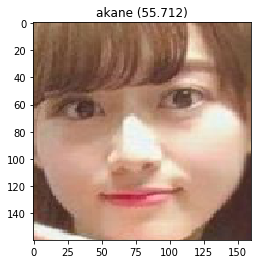

Predicted: yui (30.017)
Expected: akane


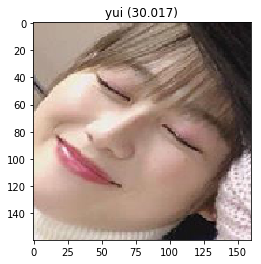

Predicted: akane (39.648)
Expected: akane


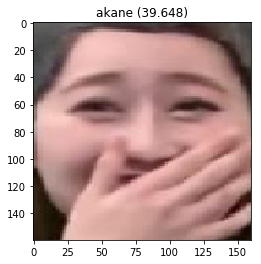

Predicted: neru (25.330)
Expected: akane


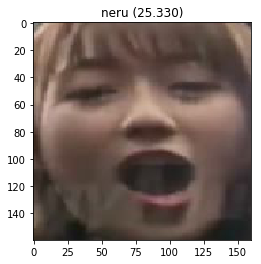

Predicted: akane (45.393)
Expected: akane


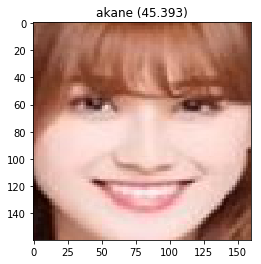

Predicted: yui (54.183)
Expected: yui


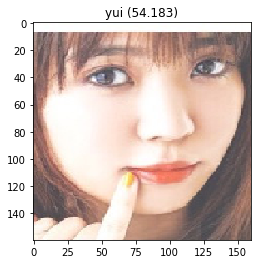

Predicted: yui (42.947)
Expected: yui


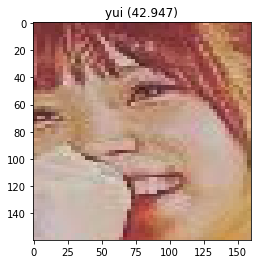

Predicted: yui (40.959)
Expected: yui


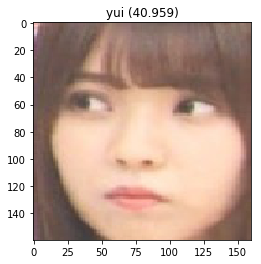

Predicted: yui (61.799)
Expected: yui


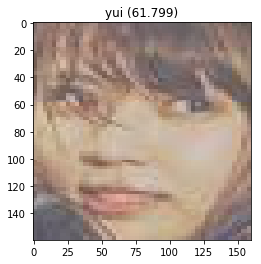

Predicted: rika (30.390)
Expected: yui


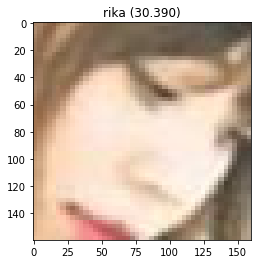

Predicted: yui (41.079)
Expected: yui


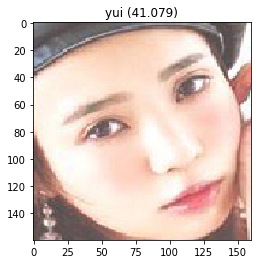

Predicted: akane (25.269)
Expected: rika


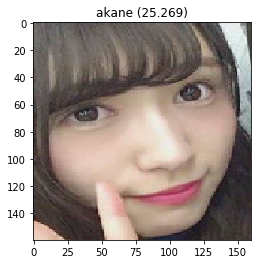

Predicted: rika (40.215)
Expected: rika


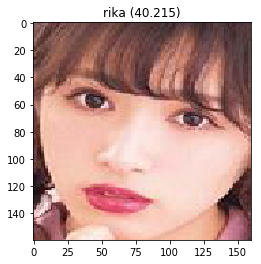

Predicted: rika (34.372)
Expected: rika


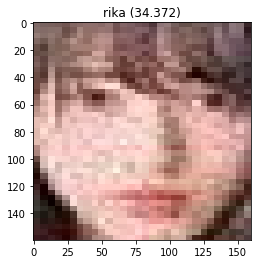

Predicted: rika (35.590)
Expected: rika


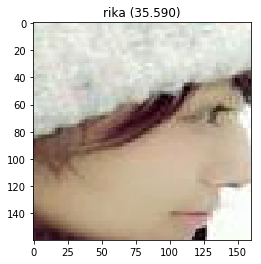

Predicted: rika (32.720)
Expected: rika


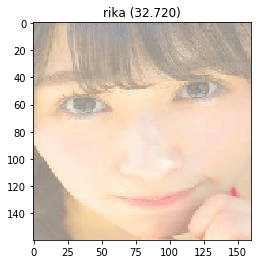

Predicted: risa (56.262)
Expected: risa


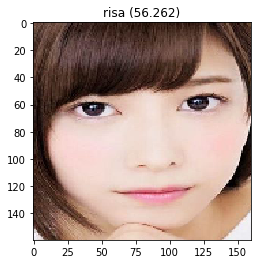

Predicted: risa (46.296)
Expected: risa


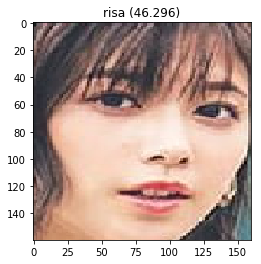

Predicted: risa (51.979)
Expected: risa


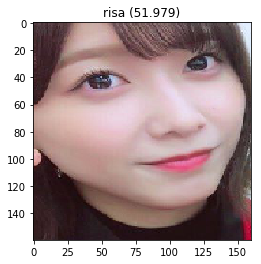

Predicted: risa (56.984)
Expected: risa


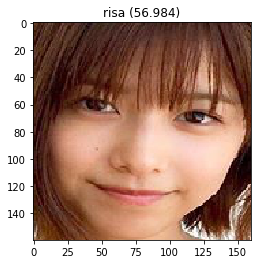

Predicted: risa (49.119)
Expected: risa


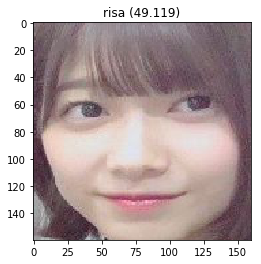

Predicted: neru (31.157)
Expected: neru


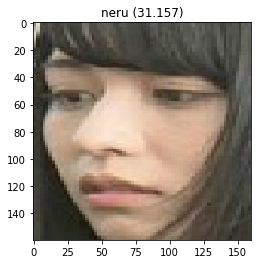

Predicted: neru (31.517)
Expected: neru


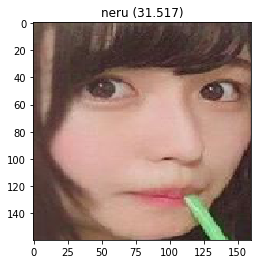

Predicted: neru (36.103)
Expected: neru


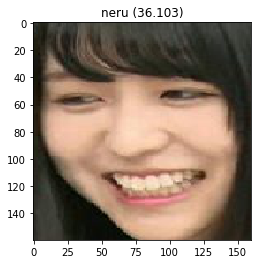

Predicted: neru (30.964)
Expected: neru


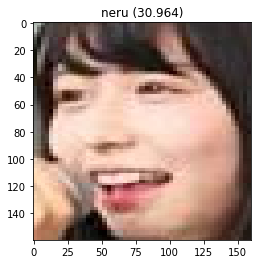

Predicted: neru (30.283)
Expected: neru


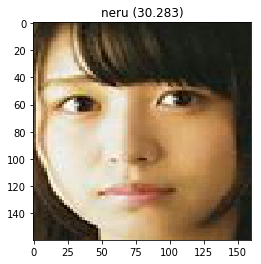

Predicted: neru (34.255)
Expected: neru


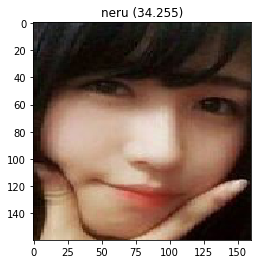

In [0]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
#for selection in range(len(testX_faces)):
78
listc = []
for  i  in  range(testX.shape[0]):
    selection = i
            # test model on a random example from the test dataset
    #selection  =  choice([i  for  i  in  range(testX.shape[0])])
    #selection = 1 #
    random_face_pixels  =  testX_faces[selection] #資料的圓形
    random_face_emb  =  testX[selection] #資料的臉
    random_face_class  =  testy[selection]
    random_face_name  =  out_encoder.inverse_transform([random_face_class])
    # prediction for the face
    samples  =  expand_dims(random_face_emb,  axis=0)
    yhat_class  =  model.predict(samples)
    yhat_prob  =  model.predict_proba(samples)
    # get name
    class_index  =  yhat_class[0]
    class_probability  =  yhat_prob[0,class_index]  *  100
    predict_names  =  out_encoder.inverse_transform(yhat_class)
    print('Predicted: %s (%.3f)'  %  (predict_names[0],  class_probability))
    print('Expected: %s'  %  random_face_name[0])
    
    #產生預測資料列表
    listc.append(predict_names[0])
    
    pyplot.imshow(random_face_pixels)
    title  =  '%s (%.3f)'  %  (predict_names[0],  class_probability)
    pyplot.title(title)
    pyplot.show()


## 2.將前一步驟的預測列表整理成指定的格式
1.合併影像名稱與預測類別 <br>
2.處理例外資料(隨機補值) <br>
3.合併預測資料與例外資料 <br>

In [0]:
print('\n合併影像名稱與預測類別')
print(len(listc))
df = pd.DataFrame(list_file)
df2 = pd.DataFrame(listc)
df =pd.concat([df,df2], axis = 1)
print(df.head())
#df.to_csv('result1.csv',index=False )

print('\n處理例外資料(隨機補值)')
except_list = []
for _ in range(len(list_except_file)):
    selection  =  choice([i  for  i  in  range(trainX.shape[0])])
    random_class  =  trainy[selection]
    random_class  =  out_encoder.inverse_transform([random_class])
    except_list.append(random_class[0])
df_except = pd.DataFrame(list_except_file)
df_except_class = pd.DataFrame(except_list)
df_except = pd.concat([df_except, df_except_class], axis = 1)
print('[%d]'%len(df_except))
print(df_except)

print('\n合併預測資料與例外資料')
df = pd.concat([df,df_except], axis = 0)
print(df)
#df.to_csv('result1.csv',index=False )


合併影像名稱與預測類別
27
     0      0
0  019  akane
1  022    yui
2  018  akane
3  020   neru
4  021  akane

處理例外資料(隨機補值)
[0]
Empty DataFrame
Columns: []
Index: []

合併預測資料與例外資料
      0      0
0   019  akane
1   022    yui
2   018  akane
3   020   neru
4   021  akane
5   017    yui
6   021    yui
7   019    yui
8   022    yui
9   020   rika
10  018    yui
11  021  akane
12  019   rika
13  018   rika
14  023   rika
15  022   rika
16  019   risa
17  018   risa
18  020   risa
19  021   risa
20  022   risa
21  018   neru
22  017   neru
23  019   neru
24  020   neru
25  022   neru
26  021   neru


# 輸出預測結果

## 1.依據classmap將預測類別的字串進行轉換

In [0]:
#原始資料
print('原始預測列表')
print(df.head(3))


#讀取SampleSubmission，尋找指定的Column name
print('根據指定的格式更改Column name')
dfSampleSubmission = pd.read_csv('/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/sample_submission.csv')
a = dfSampleSubmission.columns[0]
b = dfSampleSubmission.columns[1]
#更改Column name為指定的樣式
df.columns=[a, b]
print(df.head(3))
print('-----------')

#讀取ClassMap
print('依據Classmap做classnum的數值化轉換')
dfClassMap = pd.read_csv('/content/drive/My Drive/FaceNet_Colab/aia-tpe4-who-is-she/classmap.csv')
#用for迴圈把原始資料的class依據ClassMap做數值轉換
for _ in range(len(dfClassMap)):
  a = str(dfClassMap.loc[_]['classname'])
  b = str(dfClassMap.loc[_]['classnum'])
  df['class'] = df['class'].str.replace(a,b)
  
#顯示修改後的資料
print(df.head(3))

原始預測列表
     0      0
0  019  akane
1  022    yui
2  018  akane
根據指定的格式更改Column name
    id  class
0  019  akane
1  022    yui
2  018  akane
-----------
依據Classmap做classnum的數值化轉換
    id class
0  019     3
1  022     2
2  018     3


## 2.打印結果

In [0]:

df.to_csv('result.csv',index=False)


## 3.結束計時

In [0]:

end = time.time()
print(end - start)

134.85660982131958


# 計算正確率(Validation專用)


In [0]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset

#data  =  load('girls_embeddings20.npz')
data  =  load(new_embeddings)

trainX,  trainy,  testX,  testy  =  data['arr_0'],  data['arr_1'],  data['arr_2'],  data['arr_3']
print('Dataset: train=%d, test=%d'  %  (trainX.shape[0],  testX.shape[0]))
# normalize input vectors
in_encoder  =  Normalizer(norm='l2')
trainX  =  in_encoder.transform(trainX)
testX  =  in_encoder.transform(testX)
# label encode targets
out_encoder  =  LabelEncoder()
out_encoder.fit(trainy)
trainy  =  out_encoder.transform(trainy)
testy  =  out_encoder.transform(testy)
# fit model
model  =  SVC(kernel='linear',  probability=True)
model.fit(trainX,  trainy)
# predict
yhat_train  =  model.predict(trainX)
yhat_test  =  model.predict(testX)
# score
score_train  =  accuracy_score(trainy,  yhat_train)
score_test  =  accuracy_score(testy,  yhat_test)
# summarize
#print('Accuracy: train=%.3f, test=%.3f'  %  (score_train*100,  score_test*100))
print('Accuracy:%.3f  '%(score_test*100))

Dataset: train=30, test=27
Accuracy:85.185  
